In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
from pprint import pformat

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

from geodesic_agent import GeodesicAgent
from gridworld import Arena, Bottleneck, LinearChamber
from graph import CommunityGraph
from plot_utils import plot_replay, plot_traj, plot_need_gain
from RL_utils import oned_twod

def dict_print(d, indent_size=1):
    '''
        Fancy printing. Collapse identical, consecutive rows in input dictionary d.
    '''
    indent = ' ' * indent_size
    for kdx, key in enumerate(d.keys()):
        val = d[key]
        if kdx == 0: # No previous one to compare to
            prev_val = val
            start = kdx
            continue
        
        if val == prev_val: # Consecutive, skip
            continue
        
        # Non-consecutive, print out
        if kdx - 1 == start:
            print_key = '%d' % start
        else:
            print_key = '%d-%d' % (start, kdx - 1)
        
        print(indent + '%s: %s' % (print_key, prev_val))
        
        # Update
        start = kdx
        prev_val = val
    
    if kdx - 1 == start:
        print_key = '%d' % start
    else:
        print_key = '%d-%d' % (start, kdx - 1)

    print(indent + '%s: %s' % (print_key, prev_val))

*Open field*

In [ ]:
# Physics
width = 10
height = 7
num_states = width * height

# Build object
one_start_state = np.zeros(num_states)
one_start_state[0] = 1
all_start_states = np.ones(num_states) / num_states
init_state_dist = all_start_states

arena = Arena(width, height, init_state_distribution=init_state_dist)
all_experiences = arena.get_all_transitions()
T = arena.transitions

## Agent parameters
corner_goals = np.array([width - 1, (height - 1) * width, height * width - 1]) # Non-start corners
all_goals = np.arange(0, width * height)
goals = all_goals

alpha = 1.0
gamma = 0.95
num_replay_steps = 20

# Set up agent
ga = GeodesicAgent(arena.num_states, arena.num_actions, goals, T, alpha=alpha, gamma=gamma,
                   s0_dist=init_state_dist)
ga.curr_state = 0
ga.remember(all_experiences) # Pre-load our agent with all possible memories

## Run replay
replayed_experiences, stats_for_nerds, backups = ga.replay(num_steps=num_replay_steps, verbose=True, prospective=True)
needs, trans_needs, gains, all_MEVBs = stats_for_nerds

In [ ]:
# Plot the replayed experiences
print('First %d replay steps' % num_replay_steps, flush=True)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_replay(arena, np.array(replayed_experiences).astype(int), ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
plt.show()

# Plotting params
# params = {'min_need' : 0,
#           'max_need' : 1,
#           'alpha_fac' : 0.5}

# # Plot need, gain, MEVB throughout each of those steps
# meta_need = np.mean(needs, axis=1)
# meta_gain = np.mean(gains, axis=1)
# meta_MEVB = np.mean(all_MEVBs, axis=1)
# verbose = True

# for i in range(num_replay_steps):
#     print('step %d:' % i)
#     if verbose:
#         print('\tReplayed transition:', replayed_experiences[i])
#         print('\tBackup dictionary:')
#         dict_print(backups[i], indent_size=8)
#         print('\tReplay history:')
#         for j in range(i):
#             print('\t\t',replayed_experiences[j])

#     plot_need_gain(arena, ga.memory, np.average(meta_need[i, :, :], weights=init_state_dist, axis=0), 
#                    meta_gain[i, :], meta_MEVB[i, :], specials=[tuple(replayed_experiences[i])], params=params)
#     plt.show()

*Bottleneck chamber*

In [4]:
## Bottleneck
# Store?
save = False

# Physics
room_width = 4
corridor_width = 5
width = room_width * 2 + corridor_width
height = 5
num_states = width * height

# Build object
valid_states = Bottleneck.get_valid_states(room_width, corridor_width, height)

all_states = np.ones(num_states) / len(valid_states)
one_state = np.zeros(num_states)
one_state[26] = 1
init_state_dist = one_state

bottleneck = Bottleneck(room_width, corridor_width, height, init_state_distribution=init_state_dist)
all_experiences = bottleneck.get_all_transitions()
T = bottleneck.transitions

## Agent parameters
corner_goals = np.array([width - 1, height * width - 1]) # Non-start corners
all_goals = np.arange(num_states)
goals = corner_goals

alpha = 1.0
gamma = 0.95
num_replay_steps = 30

# Set up agent
ga = GeodesicAgent(bottleneck.num_states, bottleneck.num_actions, goals, T, alpha=alpha, gamma=gamma,
                  s0_dist=init_state_dist)
ga.curr_state = 0
ga.remember(all_experiences) # Pre-load our agent with all possible memories

## Run replay
replayed_exps, stats_for_nerds, backups = ga.replay(num_steps=num_replay_steps, verbose=True, prospective=True)
needs, trans_needs, gains, all_MEVBs = stats_for_nerds

# Save
if save:
    np.savez('Data/bottleneck_4rw_5cw.npz', replay_seqs=replayed_exps, needs=needs, gains=gains, all_MEVBs=all_MEVBs, backups=backups,
                                    room_width=room_width, corridor_width=corridor_width, height=height, num_states=num_states,
                                    alpha=alpha, gamma=gamma, num_replay_steps=num_replay_steps)

First 30 replay steps


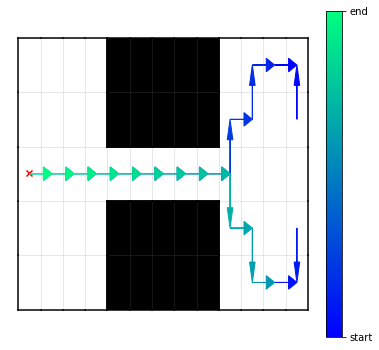

In [16]:
# Plot the replayed experiences
print('First %d replay steps' % num_replay_steps, flush=True)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_replay(bottleneck, np.array(replayed_exps).astype(int), ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
ax.scatter((0.5), (2.485), marker='x', color='r')
plt.show()

# Plotting params
# params = {'min_need' : 0,
#           'max_need' : 1}

# Plot need, gain, MEVB throughout each of those steps
# meta_need = np.mean(needs, axis=1)
# meta_gain = np.mean(gains, axis=1)
# meta_MEVB = np.mean(all_MEVBs, axis=1)
# verbose = True

# for i in range(min(num_replay_steps, 50)):
#     print('step %d:' % i)
#     if verbose:
#         print('\tReplayed transition:', replayed_exps[i])
#         print('\tBackup dictionary:')
#         dict_print(backups[i], indent_size=8)
#         print('\tReplay history:')
#         for j in range(i):
#             print('\t\t',replayed_exps[j]) # so dumb

#     plot_need_gain(bottleneck, ga.memory, np.average(meta_need[i, :, :], weights=init_state_dist, axis=0), 
#                    meta_gain[i, :], meta_MEVB[i, :], specials=[tuple(replayed_exps[i])], params=params)
#     plt.show()

*Linear chamber*

In [ ]:
## Linear chamber
# Physics
length = 30

# Build object
init_state_dist = np.ones(length) / length
tunnel = LinearChamber(length, init_state_distribution=init_state_dist)
all_experiences = tunnel.get_all_transitions()
T = tunnel.transitions

## Agent parameters
goal_states = np.array([length - 1]) # Non-start corners
goal_states = np.arange(length)
alpha = 1.0
gamma = 0.95
num_replay_steps = 50

# Set up agent
ga = GeodesicAgent(tunnel.num_states, tunnel.num_actions, goal_states, T, alpha=alpha, gamma=gamma,
                  s0_dist=init_state_dist)
ga.curr_state = 0
ga.remember(all_experiences) # Pre-load our agent with all possible memories

## Run replay
replayed_experiences, stats_for_nerds, backups = ga.replay(num_steps=num_replay_steps, verbose=True, prospective=True)
needs, trans_needs, gains, all_MEVBs = stats_for_nerds

In [ ]:
# Plot the replayed experiences
print('First %d replay steps' % num_replay_steps, flush=True)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_replay(tunnel, np.array(replayed_experiences).astype(int), ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
plt.show()

# Plotting params
params = {'min_need' : 0,
          'max_need' : 1}

# Plot need, gain, MEVB throughout each of those steps
# meta_need = np.mean(needs, axis=1)
# meta_gain = np.mean(gains, axis=1)
# meta_MEVB = np.mean(all_MEVBs, axis=1)
# verbose = True

# for i in range(num_replay_steps):
#     print('step %d:' % i)
#     if verbose:
#         print('\tReplayed transition:', replayed_experiences[i])
#         print('\tBackup dictionary:')
#         dict_print(backups[i], indent_size=8)
#         print('\tReplay history:')
#         for j in range(i):
#             print('\t\t',replayed_experiences[j]) # so dumb

#     plot_need_gain(tunnel, ga.memory, np.average(meta_need[i, :, :], weights=init_state_dist, axis=0), 
#                    meta_gain[i, :], meta_MEVB[i, :], specials=[tuple(replayed_experiences[i])], params=params)
#     plt.show()

*Community graph*

In [ ]:
## Community graph, a la Anna Schapiro

# Reproducibility
np.random.seed(865612)

# Store?
save = True

# Physics
num_nbrhds = 3
num_nbrs = 5
num_states = num_nbrhds * num_nbrs

# Build object
init_state_dist = np.ones(num_states) / num_states
cg = CommunityGraph(num_nbrhds, num_nbrs, init_state_dist)
all_experiences = cg.get_all_transitions()
T = cg.transitions

## Agent parameters
goal_states = np.arange(num_states)
alpha = 1.0
gamma = 0.95
num_replay_steps = 100

# Set up agent
ga = GeodesicAgent(cg.num_states, cg.num_actions, goal_states, T, alpha=alpha, gamma=gamma,
                  s0_dist=init_state_dist)
ga.curr_state = 0
ga.remember(all_experiences) # Pre-load our agent with all possible memories

## Run replay
check_convergence = False
conv_thresh = 1e-8
replayed_exps, stats_for_nerds, backups = ga.replay(num_steps=num_replay_steps, verbose=True, prospective=True,
                                                    check_convergence=check_convergence, convergence_thresh=conv_thresh)
needs, gains, all_MEVBs = stats_for_nerds

# Save
if save:
    np.savez('Data/cg_3hd_5rs.npz', replay_seqs=replayed_exps, needs=needs, gains=gains, all_MEVBs=all_MEVBs, backups=backups,
                                    num_nbrhds=num_nbrhds, num_nbrs=num_nbrs, num_states=num_states,
                                    alpha=alpha, gamma=gamma, num_replay_steps=num_replay_steps)

In [ ]:
print(replayed_exps[:20])

In [ ]:
print(replayed_exps.shape)
for i in range(5):
    for j in range(5):
        print('start: %d, end: %d, GR: %.2f' % (i, j, ga.G[i, 0, j]))
plt.figure(figsize=(14, 14))
plt.imshow(ga.G[:, 0, :])
plt.colorbar()

In [ ]:
for s in range(num_states):
    print()
    for g in range(num_states):
        print(s, g, np.max(ga.G[s, :, g]))